# Step 6

## Decode the gradients with NeuroSynth topics

Here we take another approach for interpreting the gradients - decode them using spatial maps from automatic, meta-analytic database (Yarkoni et al. 2011, Poldrack et al. 2012)

#### References
- Yarkoni, T., Poldrack, R.A., Nichols, T.E., Van Essen, D.C. and Wager, T.D., 2011. Large-scale automated synthesis of human functional neuroimaging data. Nature methods, 8(8), pp.665-670.

- Poldrack, R.A., Mumford, J.A., Schonberg, T., Kalar, D., Barman, B. and Yarkoni, T., 2012. Discovering relations between mind, brain, and mental disorders using topic mapping. PLoS Comput Biol, 8(10), p.e1002707.

In [136]:
%matplotlib inline

from nilearn.datasets import load_mni152_template
from nilearn import plotting, image
import nibabel as nib

import statsmodels.api as sm
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 18

import numpy as np
import glob

### Convert 50-topic solution maps to CIFTI

For this step, we need to combine the topic files into a 4D image and convert them to a CIFTI file.

To convert NIFTI to CIFTI, you need to run the 'nifti_to_cifti.sh topics_25.nii.gz topics25.dscalar.nii' script from ../data/cifti folder. It takes the topic-maps concatenated into a 4D file and produces a CIFTI version of them. In the following steps, we relate the gradients to these maps.

### Map gradients to Neurosynth topics

In [126]:
tfiles = glob.glob('../data/Neurosynth_topic_maps/*.nii.gz')

topicname = np.array(['_'.join(t.split('/')[-1].split('_')[2:5]) for t in tfiles])
np.savetxt('../data/cifti/topics.txt', topicname, fmt = '%s')

In [103]:
gradients = nib.load('../data/rsFC_eigenvectors.dscalar.nii').get_data().T
gradients = sm.add_constant(gradients[:,0:3])

topics = nib.load('../data/cifti/topics25.dscalar.nii').get_data().T
topicname = np.genfromtxt('../data/cifti/topics.txt', dtype = str)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


### Fit gradients to topic maps

In [115]:
coefs = np.zeros([topics.shape[1],5])

print "Topic                                         G1         G2          G3        F         p"
print "==============================================================================================="
for i in range(topics.shape[1]): 
    ols = sm.OLS(topics[:,i], gradients)
    ols = ols.fit(cov_type="HAC", cov_kwds={'maxlags':1000})
    #ols_null = sm.OLS(topics[:,i], np.ones(gradients.shape[0]))
    #ols_null = ols_null.fit(cov_type="HAC", cov_kwds={'maxlags':5000})
    coefs[i,0:3] = ols.params[1:4]
    coefs[i,3] = ols.fvalue
    coefs[i,4] = ols.f_pvalue
    print "%-40s      %-6.2f     %-6.2f      %-6.2f    %-6.2f    %-6.4f" % (topicname[i], 
                                                                  ols.params[1], ols.params[2], ols.params[3],
                                                                  ols.fvalue, ols.f_pvalue)

Topic                                         G1         G2          G3        F         p
action_actions_motor                          -0.31      0.06        0.01      9.65      0.0000
object_objects_category                       -0.09      0.29        -0.06     5.34      0.0011
task_performance_cognitive                    0.04       0.10        0.25      8.58      0.0000
visual_auditory_sensory                       -0.15      0.11        -0.11     13.25     0.0000
face_faces_recognition                        -0.10      0.33        -0.11     4.62      0.0031
language_hemispheric_lateralization           -0.00      -0.00       0.00      3.11      0.0253
inhibition_response_inhibitory                0.02       -0.02       0.05      6.76      0.0001
motion_visual_perception                      -0.27      0.51        -0.04     11.03     0.0000
memory_retrieval_encoding                     0.34       0.10        -0.42     12.57     0.0000
eye_spatial_gaze                             

### Select topics that can be explained by gradients

We select only the topics, for which at least gradient receives |weight| > 0.05. An alternative would be to select them using p-values, but that would be trading one arbitrary criterion for another. In the end, we preserve 23 of 50 topics.

In [127]:
max_coefs = np.max(coefs[:,0:3], axis = 1)
good = np.where(np.logical_or(max_coefs > 0.05, max_coefs < -0.05))[0]

In [128]:
topicname[good]

array(['action_actions_motor', 'object_objects_category',
       'task_performance_cognitive', 'visual_auditory_sensory',
       'face_faces_recognition', 'inhibition_response_inhibitory',
       'motion_visual_perception', 'memory_retrieval_encoding',
       'eye_spatial_gaze', 'social_participants_empathy',
       'reading_language_words', 'memory_working_wm',
       'reward_decision_risk', 'speech_auditory_sounds',
       'stimulation_somatosensory_tms', 'sentences_comprehension_language',
       'emotional_negative_emotion', 'attention_attentional_visual',
       'number_numerical_arithmetic', 'semantic_words_word',
       'conflict_response_trials', 'pain_painful_stimulation',
       'motor_movement_movements'], 
      dtype='|S35')

In [129]:
topicname_clean = ['action','object',
                   'performance','sensory',
                   'face', 'inhibition',
                   'perception','retrieval',
                   'eye','social',
                   'language','working_memory',
                   'reward','auditory',
                   'somatosensory','comprehension', 
                   'emotion', 'attention', 
                   'number','semantic',
                   'response_conflict','pain',
                   'movement']

### Compare original topic names with simplified version

In [130]:
zip(topicname[good], topicname_clean)

[('action_actions_motor', 'action'),
 ('object_objects_category', 'object'),
 ('task_performance_cognitive', 'performance'),
 ('visual_auditory_sensory', 'sensory'),
 ('face_faces_recognition', 'face'),
 ('inhibition_response_inhibitory', 'inhibition'),
 ('motion_visual_perception', 'perception'),
 ('memory_retrieval_encoding', 'retrieval'),
 ('eye_spatial_gaze', 'eye'),
 ('social_participants_empathy', 'social'),
 ('reading_language_words', 'language'),
 ('memory_working_wm', 'working_memory'),
 ('reward_decision_risk', 'reward'),
 ('speech_auditory_sounds', 'auditory'),
 ('stimulation_somatosensory_tms', 'somatosensory'),
 ('sentences_comprehension_language', 'comprehension'),
 ('emotional_negative_emotion', 'emotion'),
 ('attention_attentional_visual', 'attention'),
 ('number_numerical_arithmetic', 'number'),
 ('semantic_words_word', 'semantic'),
 ('conflict_response_trials', 'response_conflict'),
 ('pain_painful_stimulation', 'pain'),
 ('motor_movement_movements', 'movement')]

## Plot the topics

In [131]:
coefs_thr = coefs[good,:]
topicname_thr = topicname[good]

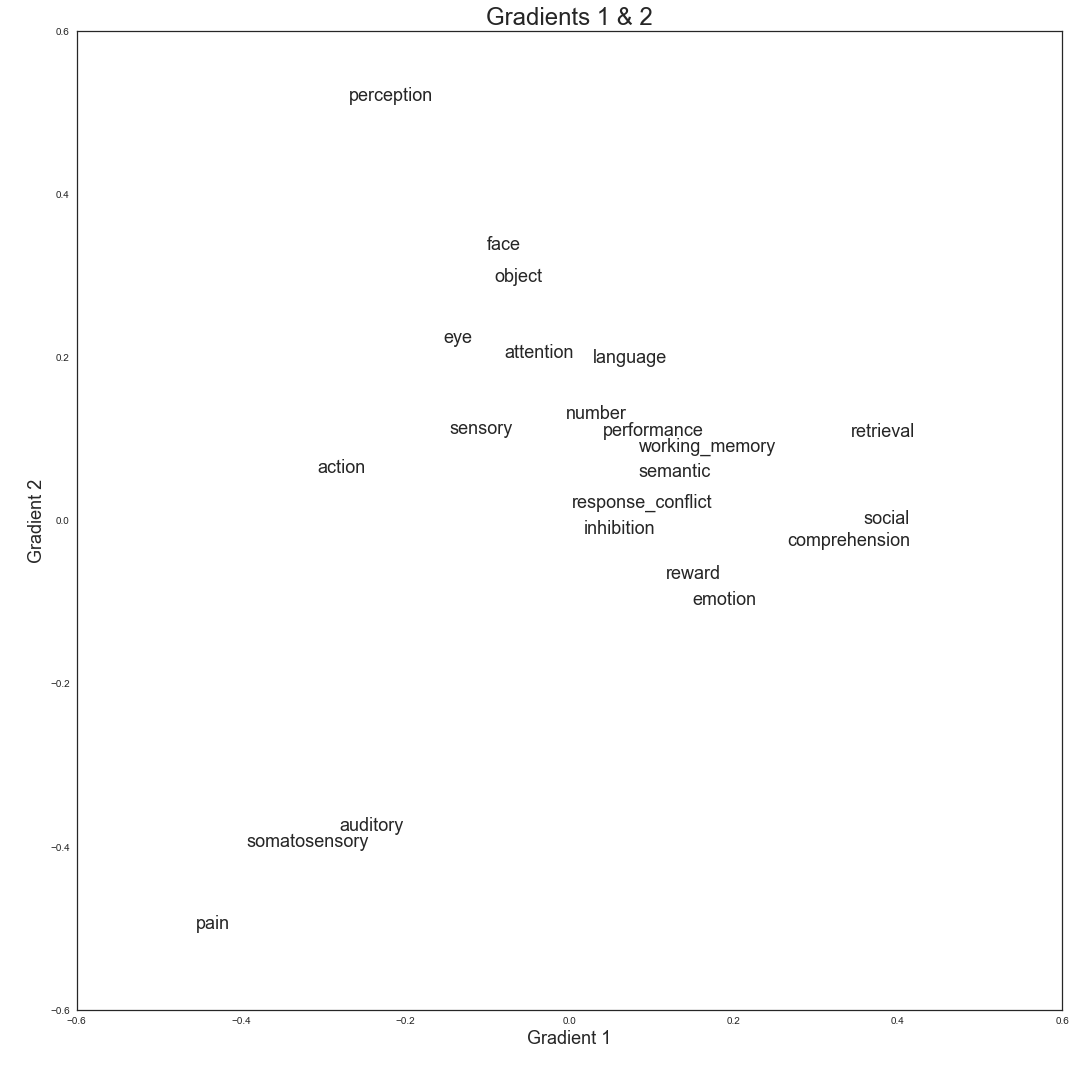

In [152]:
sns.set_style('white')

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)
#ax.scatter(coefs_thr[:,0], coefs_thr[:,1], s = 100, c = 'red')

for i in range(len(topicname_clean)):
    ax.annotate(topicname_clean[i], xy=(coefs_thr[i,0], coefs_thr[i,1]), 
                xytext=(coefs_thr[i,0], coefs_thr[i,1]),
                #arrowprops=dict(facecolor='black', shrink=0.05),
                )


ax.set_xlim(-0.6,0.6)
ax.set_ylim(-0.6,0.6)

ax.set_title('Gradients 1 & 2', fontsize = 24)
ax.set_xlabel('Gradient 1', fontsize = 18)
ax.set_ylabel('Gradient 2', fontsize = 18)

plt.tight_layout()

#plt.savefig('G_12_terms_surface.pdf')

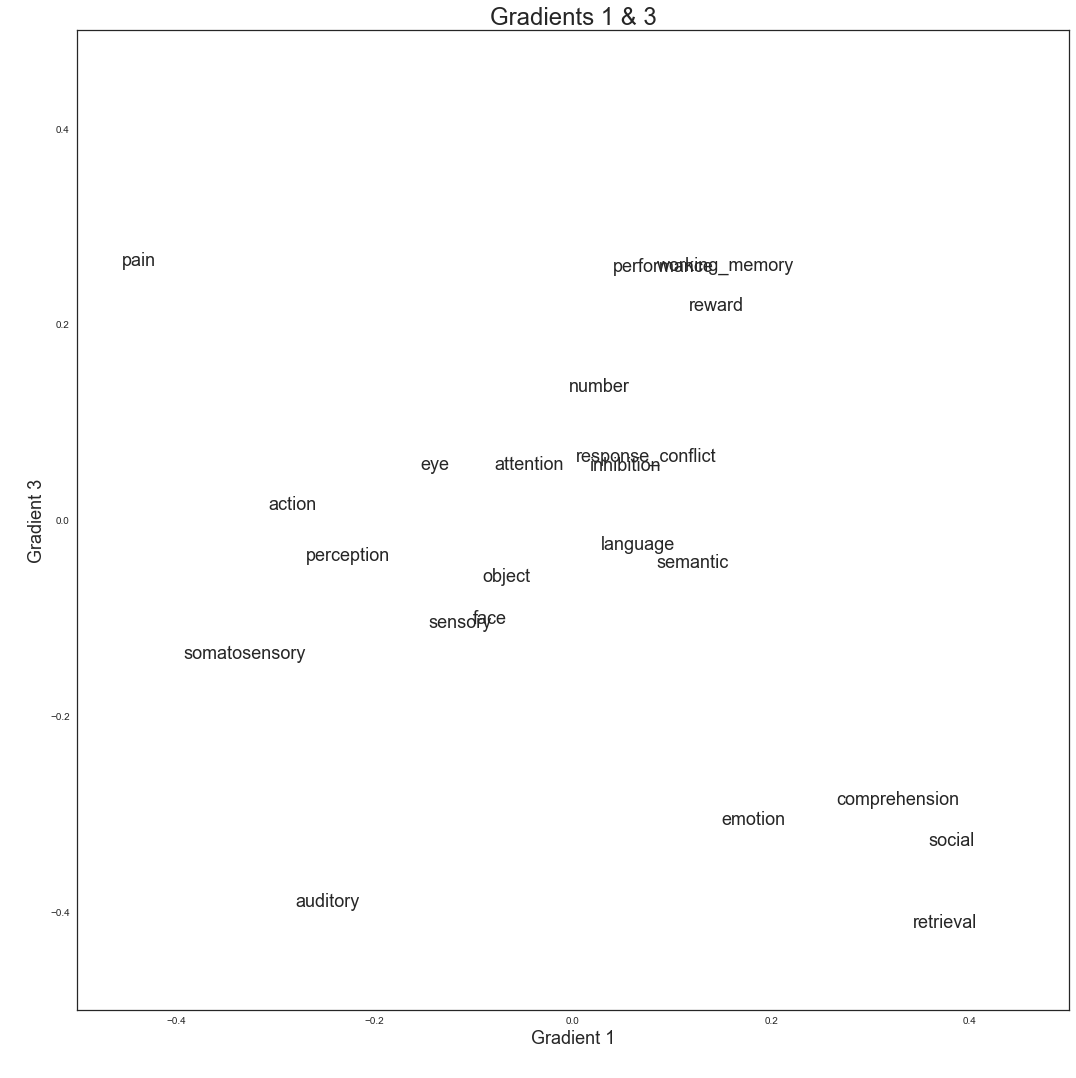

In [149]:
sns.set_style('white')

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)

for i in range(len(topicname_clean)):
    ax.annotate(topicname_clean[i], xy=(coefs_thr[i,0], coefs_thr[i,2]), 
                xytext=(coefs_thr[i,0], coefs_thr[i,2]),
                #arrowprops=dict(facecolor='black', shrink=0.05),
                )

ax.set_ylim(-0.5,0.5)
ax.set_xlim(-0.5,0.5)

ax.set_title('Gradients 1 & 3', fontsize = 24)
ax.set_xlabel('Gradient 1', fontsize = 18)
ax.set_ylabel('Gradient 3', fontsize = 18)

plt.tight_layout()

#plt.savefig('G_13_terms.pdf')

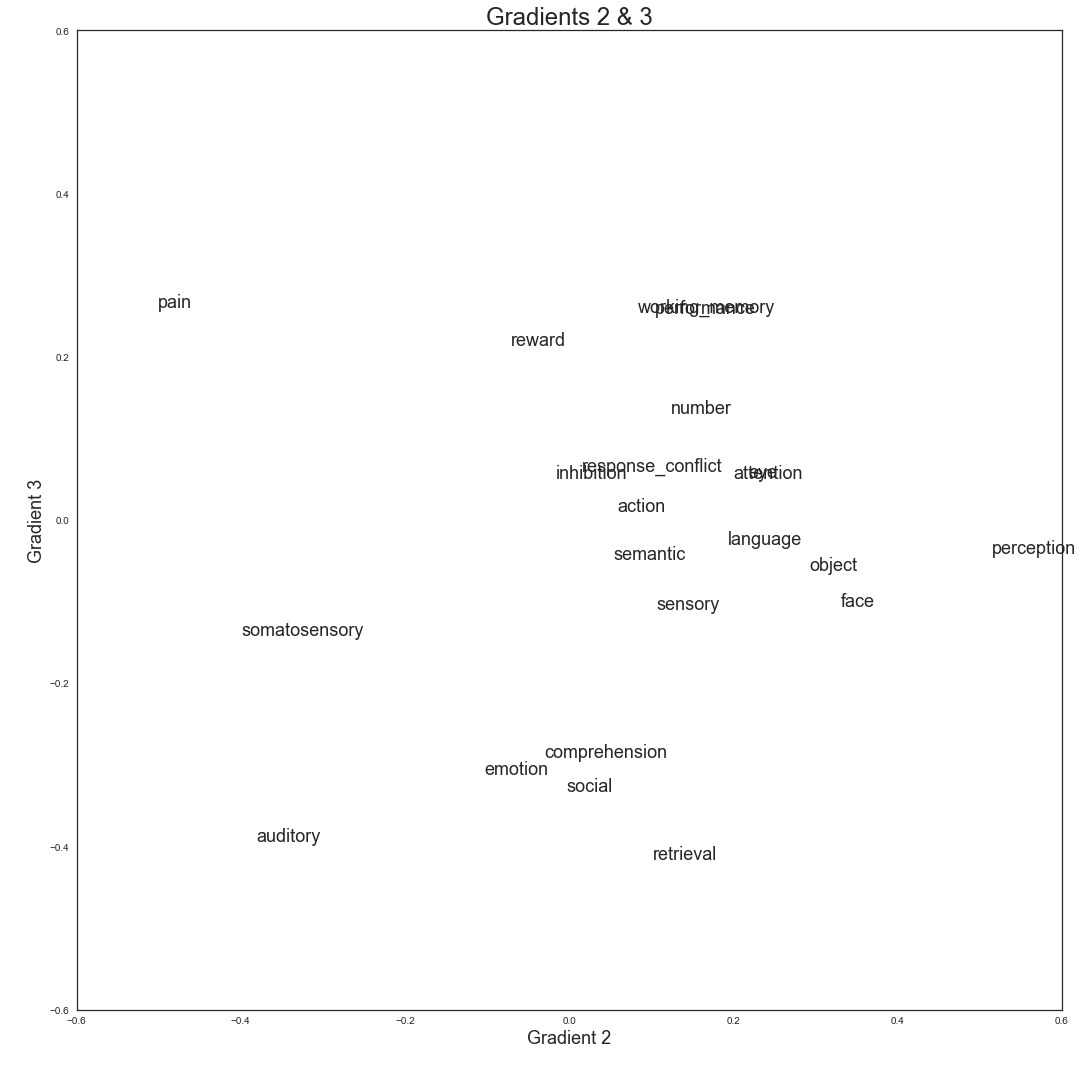

In [151]:
sns.set_style('white')

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(111)
#ax.scatter(coefs_thr[:,0], coefs_thr[:,1], s = 100, c = 'red')

for i in range(len(topicname_clean)):
    ax.annotate(topicname_clean[i], xy=(coefs_thr[i,1], coefs_thr[i,2]), 
                xytext=(coefs_thr[i,1], coefs_thr[i,2]),
                #arrowprops=dict(facecolor='black', shrink=0.05),
                )


ax.set_xlim(-0.6,0.6)
ax.set_ylim(-0.6,0.6)

ax.set_title('Gradients 2 & 3', fontsize = 24)
ax.set_xlabel('Gradient 2', fontsize = 18)
ax.set_ylabel('Gradient 3', fontsize = 18)

plt.tight_layout()

#plt.savefig('G_23_terms_surface.pdf')